## Liberaries

In [7]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import datetime
from datetime import datetime
from datetime import date, timedelta
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
#import spacy
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf
import keras
from keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from keras.layers import Dense

## Functions

In [2]:
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)

def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

## Import Data

In [3]:
df_raw = pd.read_csv(r'E:\Data\Canmet\ML\pipeline\all_us.csv', encoding = "ISO-8859-1")
df_raw.rename(columns={'Reported Cause of Incident': 'cause', 'Operator Name': 'name', 'cause_sub ': 'cause_sub', 'System Type': 'system', 'Fatalities': 'fatal', 'Total Cost Current Year Dollars': 'cost'}, inplace=True)
df = df_raw.drop(['Cost_Reported', 'Report ID', 'Operator ID', 'County'], axis = 1)

## Rename child companies

In [4]:
companies = [ 'williams ','western refining','vintage ', 'valero','unocal ','union oil','ugi ','torrance ','tesoro' ,'teppco ','targa ','sunoco ','shell ','public service ','plains ','phillips ','peoples ','oryx ','oneok ','nustar ','northern states power','national fuel','mustang ','mobil ','midcoast ','mid-continent','mid - valley', 'markwest ', 'marathon ', 'magellan','lone star', 'liberty ', 'genesis ', 'harvest', 'ldh energy', 'kinetica ', 'koch ', 'keyspan ', 'kinder morgan', 'interstate ', 'gulf ', 'great lakes', 'enable gas ', 'exxonmobil ', 'equistar ', 'express ', 'entergy ', 'energy xxi', 'enron ', 'enlink ', 'enbridge ', 'dow pipeline','duke energy', 'consumers ''alliant energy', 'bridger ', 'dominion energy', 'denbury ', 'corning ', 'delek ', 'chesapeake ', 'consolidated edison', 'centerpoint energy', 'columbia gas ', 'chevron ', 'conocophillips ', 'buckeye ', 'citgo ', 'colonial ', 'citizens ', 'bridgeline ', 'american midstream', 'amoco ', 'aquila ', 'atmos energy', 'avista ', 'boardwalk ', 'bp ', 'bridgeline ']
#reduces number of companies from 920 to 600
df['name'] = df['name'].apply(lambda x: x.lower() if type(x)== str else x)

for word in companies:
    df['name'] =  df['name'].apply(lambda x: word if type(x)==str and word in x else x)
df = df.fillna(method='ffill')
df

,Date,cause,cause_sub,State,name,system,fatal,Injuries,cost,b_spilled,b_lost
0,01/01/1999,MATERIAL/WELD/EQUIP FAILURE,UNSPECIFIED WELD,TX,american petrofina pipeline co,HAZARDOUS LIQUID,0,0,700896,50,47
1,01/02/1999,MATERIAL/WELD/EQUIP FAILURE,UNSPECIFIED MATERIAL/WELD FAILURE,OR,northwest pipeline llc,GAS TRANSMISSION,0,0,737785,0,0
2,01/03/1999,ALL OTHER CAUSES,MISCELLANEOUS,AR,koch,HAZARDOUS LIQUID,0,0,0,1,1
3,01/03/1999,CORROSION,UNSPECIFIED CORROSION,VA,atmos energy,GAS DISTRIBUTION,0,0,737785,0,0
4,01/03/1999,EXCAVATION DAMAGE,UNSPECIFIED EXCAVATION DAMAGE,VA,"east tennessee natural gas, llc (spectra energ...",GAS TRANSMISSION,0,0,184446,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12634,12/17/2019,INCORRECT OPERATION,INCORRECT VALVE POSITION,OK,"bkep pipeline, llc",HAZARDOUS LIQUID,0,0,0,2,0
12635,12/17/2019,MATERIAL/WELD/EQUIP FAILURE,MALFUNCTION OF CONTROL/RELIEF EQUIPMENT,TX,energy transfer company,GAS TRANSMISSION,0,0,15559,0,0
12636,12/18/2019,MATERIAL/WELD/EQUIP FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,LA,mobil,HAZARDOUS LIQUID,0,0,160550,7,7
12637,12/19/2019,ALL OTHER CAUSES,MISCELLANEOUS,PA,philadelphia gas works,GAS DISTRIBUTION,2,0,1416920,0,0


## Adding/OHE Features 

In [5]:
dfk = df
dfk['day'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%a'))
dfk['month'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%b'))
x = np.asarray(dfk[['State', 'name', 'system', 'day', 'month']])
y = np.asarray(dfk[['cause']])
y = y.reshape(len(y),)

encoded_x = None
for i in range(0, x.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(x[:,i])
    feature = feature.reshape(x.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    feature = onehot_encoder.fit_transform(feature)
    if encoded_x is None:
        encoded_x = feature
    else:
            encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: : ", encoded_x.shape)
#state:53+day:7+m:12+name:689+system:6 : 767
#y = y.reshape(-1,1)
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
encoded_y = label_encoder.transform(y)
print("y shape: : ", encoded_y.shape)

X shape: :  (12639, 767)
y shape: :  (12639,)


In [10]:
y = np.asarray(dfk[['cause']])
encoded_y = None
for i in range(0, y.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(y[:,i])
    feature = feature.reshape(y.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    feature = onehot_encoder.fit_transform(feature)
    if encoded_y is None:
        encoded_y = feature
    else:
            encoded_y = np.concatenate((encoded_y, feature), axis=1)
print("y shape: : ", encoded_y.shape)

y shape: :  (12639, 7)


In [15]:
encoded_y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [6]:
test_size = 0.25
seed = 44
x_train, x_test, y_train, y_test = train_test_split(encoded_x, encoded_y, test_size=test_size, random_state=seed)

### KNN

In [8]:
k = []
for K in range(4,15):
        K = K+1
        start = time.time()
        k.append(K)
        model = neighbors.KNeighborsClassifier(n_neighbors = K)
        model.fit(x_train, y_train)  
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        print(K,'time: ',(time.time()-start), accuracy_score(y_train, prediction_train),accuracy_score(y_test, prediction_test))

5 time:  175.9810655117035 0.5675704188205507 0.37436708860759493
6 time:  175.29802632331848 0.5497415339170798 0.37436708860759493
7 time:  175.62804532051086 0.5416183141681612 0.3848101265822785
8 time:  174.18096256256104 0.5369764743116362 0.3886075949367089
9 time:  169.32168459892273 0.5213630129760524 0.3996835443037975
10 time:  169.1456744670868 0.5195695748496677 0.41012658227848103
11 time:  169.3306851387024 0.5137672750290115 0.41455696202531644
12 time:  169.4196901321411 0.5136617786686359 0.42563291139240506
13 time:  169.41769003868103 0.5068045152442241 0.425
14 time:  170.20973539352417 0.5023736681084503 0.43386075949367087
15 time:  168.6926486492157 0.4959383901255407 0.4316455696202532


In [8]:
start = time.time()
model = RandomForestClassifier()
model.fit(x_train, y_train)  
prediction_train = model.predict(x_train)
prediction_test = model.predict(x_test)
print('time: ',(time.time()-start), accuracy_score(y_train, prediction_train),accuracy_score(y_test, prediction_test))

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time:  1.2900738716125488 0.8856419453528853 0.3943037974683544


In [11]:
n_estimators, max_depths, min_samples_split, min_samples_leaf = [150], [35,40, 45], [5], [2]

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                print(round(time.time() - start_time,2), accuracy_score(y_train, prediction_train),
        accuracy_score(y_test, prediction_test),estimators, max_depth, min_sample_split,min_sample_leaf)


8.28 0.4933009811161515 0.46867088607594937 150 35 5 2
8.46 0.500263740900939 0.4718354430379747 150 40 5 2
8.65 0.5046945880367127 0.47056962025316457 150 45 5 2


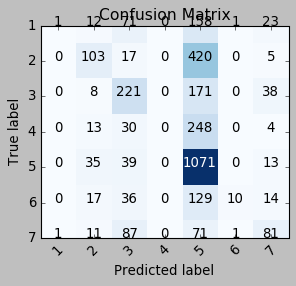

In [12]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test,normalize=False, classes= ['1', '2', '3', '4', '5', '6', '7'],title='Confusion Matrix')

In [ ]:
#np.random.seed(141)
units = 10000
epochs = 3
batch_size = 64
lr = 0.00001

model = tf.keras.Sequential()
model.add(layers.Dense(units = units,input_dim = 767, activation='relu'))
model.add(layers.Dense(units = int(units), activation='relu'))
model.add(layers.Dense(units = int(units), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
#model.compile(loss = 'mse',  optimizer = "adam")
opt = SGD(lr=lr, momentum=0.9, decay=0.001)
model.compile(optimizer = opt, loss='binary_crossentropy' ,  metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size = batch_size, verbose = 1)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
prediction_train = model.predict(x_train)
prediction_test = model.predict(x_test)
#Y_train, Y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
print(accuracy_score(onehot_encoder.inverse_transform(y_train), onehot_encoder.inverse_transform(prediction_train)),accuracy_score(onehot_encoder.inverse_transform(y_test), onehot_encoder.inverse_transform(prediction_test)))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10000)             7680000   
_________________________________________________________________
dense_32 (Dense)             (None, 10000)             100010000 
_________________________________________________________________
dense_33 (Dense)             (None, 10000)             100010000 
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 70007     
Total params: 207,770,007
Trainable params: 207,770,007
Non-trainable params: 0
_________________________________________________________________
Train on 9479 samples, validate on 3160 samples
Epoch 1/3


In [27]:
Y_train, Y_test, Prediction_train, Prediction_test = onehot_encoder.inverse_transform(y_train), onehot_encoder.inverse_transform(y_test),onehot_encoder.inverse_transform(prediction_train), onehot_encoder.inverse_transform(prediction_test)

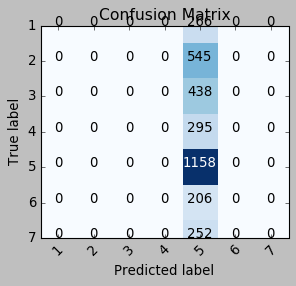

In [29]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(Y_test,Prediction_test,normalize=False, classes= ['1', '2', '3', '4', '5', '6', '7'],title='Confusion Matrix')

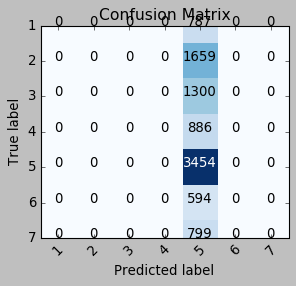

In [31]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(Y_train,Prediction_train,normalize=False, classes= ['1', '2', '3', '4', '5', '6', '7'],title='Confusion Matrix')

## Aggregate by Name

In [10]:
df_g = df[['name', 'cost']].groupby(['name']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_g.columns =['name', 'mean cost', 'count', 'max cost', 'sum cost']
df_g = df_g.sort_values('count', ascending = False).reset_index(drop=True)
df_g.head()

,name,mean cost,count,max cost,sum cost
0,magellan,266905.802905,482,11637558,128648597
1,sunoco,222912.604061,394,20152935,87827566
2,enterprise crude pipeline llc,195844.842239,393,10261220,76967023
3,enterprise products operating llc,863811.586563,387,78443170,334295084
4,plains,556226.942105,380,153683744,211366238


## Aggregate by Cause

In [191]:
df_g = df[['cause', 'cost']].groupby(['cause']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_g.columns =['cause', 'mean cost', 'count', 'max cost', 'sum cost']
df_g = df_g.sort_values('count', ascending = False).reset_index(drop=True)
df_g

,cause,mean cost,count,max cost,sum cost
0,MATERIAL/WELD/EQUIP FAILURE,6.947303e+05,4612,981433193,3204096160
1,CORROSION,5.612120e+05,2204,153683744,1236911186
2,EXCAVATION DAMAGE,4.100171e+05,1738,21825500,712609655
3,INCORRECT OPERATION,9.688836e+05,1181,748748658,1144251502
4,ALL OTHER CAUSES,5.915379e+05,1053,66400651,622889428
5,OTHER OUTSIDE FORCE DAMAGE,6.610029e+05,1051,55338695,694714006
6,NATURAL FORCE DAMAGE,2.961140e+06,800,598475223,2368911950


## Aggregate by SubCause

In [11]:
df_g = df[['cause_sub', 'cost']].groupby(['cause_sub']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_g.columns =['cause_sub', 'mean cost', 'count', 'max cost', 'sum cost']
df_g = df_g.sort_values('sum cost', ascending = False).reset_index(drop=True)
df_g.head()

,cause_sub,mean cost,count,max cost,sum cost
0,HEAVY RAINS/FLOODS,6.095538e+06,211,598475223,1286158447
1,ENVIRONMENTAL CRACKING-RELATED,1.654412e+07,73,981433193,1207721085
2,MANUFACTURING-RELATED,7.274578e+06,125,651839895,909322234
3,PIPELINE/EQUIPMENT OVERPRESSURED,1.359178e+07,57,748748658,774731550
4,EXTERNAL,8.332822e+05,821,153683744,684124714


## Trend in Natural Effects

In [14]:
df_sec = df.loc[df['cause'] == 'NATURAL FORCE DAMAGE']
df_sec.reset_index(drop=True, inplace=True)

In [18]:
df_sec['month'] = df_sec.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%Y-%m'))
import warnings
warnings.filterwarnings('ignore')

### Monthly

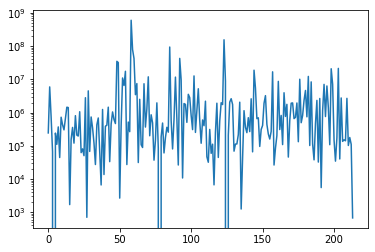

In [237]:
df_w = df_sec[['cost', 'month']].groupby(['month']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_w.columns =['week', 'cost', 'count', 'max', 'sum']
plt.plot(range(len(df_w)), df_w['max'])
pyplot.yscale('log')

### Weekly

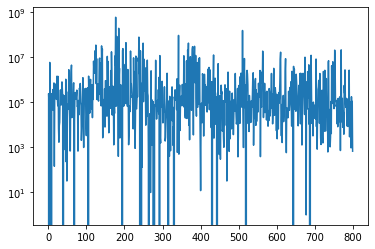

In [205]:
plt.plot(range(len(df_sec)), df_sec.cost)
pyplot.yscale('log')
plt.show()

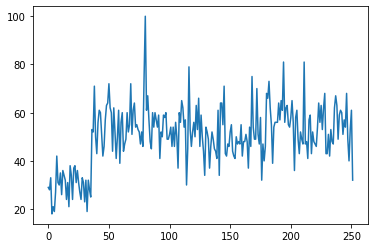

In [33]:
df_ = df
df_['month'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%Y-%m'))
df_['week'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%Y-%W'))
df_m = df_[['cost', 'month']].groupby(['month']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_m.columns =['month', 'cost', 'count', 'max', 'sum']
plt.plot(range(len(df_m)), df_m['count'])
#pyplot.yscale('log')

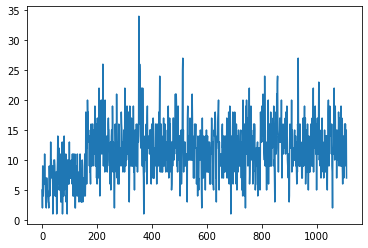

In [31]:
df_w = df_[['cost', 'week']].groupby(['week']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_w.columns =['week', 'cost', 'count', 'max', 'sum']
plt.plot(range(len(df_w)), df_w['count'])
#pyplot.yscale('log')

In [ ]:
counties = list(df_raw['County'].unique())
matching = [s for s in counties if "VALERO" == s]
matching

In [37]:
names = (df_raw['name'].unique()).astype(str)
#len(names) = 922
names = sorted(names)
names

['ACADIAN GAS PIPELINE SYSTEM',
 'ADAIRSVILLE, CITY OF',
 'AGRIUM US, INC',
 'AIM PIPELINE CO',
 'AIR PRODUCTS & CHEMICALS INC',
 'ALASKA PIPELINE CO',
 'ALBEMARLE CORPORATION',
 'ALGONQUIN GAS TRANSMISSION, L.L.C. (SPECTRA ENERGY PARTNERS, LP)',
 'ALLIANT ENERGY - INTERSTATE POWER AND LIGHT COMPANY',
 'ALLIANT ENERGY - WISCONSIN POWER & LIGHT CO',
 'ALLIANT GAS',
 'ALON USA, LP',
 'ALYESKA PIPELINE SERVICE CO',
 'AMEREN ILLINOIS COMPANY',
 'AMERENCILCO',
 'AMERENCIPS',
 'AMERENIP',
 'AMERENUE',
 'AMERICAN COASTAL ENERGY INC',
 'AMERICAN MIDSTREAM (ALATENN), LLC',
 'AMERICAN MIDSTREAM (LOUISIANA INTRASTATE), LLC',
 'AMERICAN MIDSTREAM (MIDLA), LLC',
 'AMERICAN MIDSTREAM (SEACREST), LP',
 'AMERICAN MIDSTREAM (SIGCO INTRASTATE), LLC',
 'AMERICAN MIDSTREAM BAKKEN, LLC',
 'AMERICAN PETROFINA PIPELINE CO',
 'AMERIGAS PROPANE LP',
 'AMID SILVER DOLLAR PIPELINE LLC',
 'AMOCO OIL CO',
 'AMOCO PIPELINE CO',
 'ANADARKO PETROLEUM CORP',
 'ANDEAVOR FIELD SERVICES LLC',
 'ANR PIPELINE CO',
 'APPALA

In [ ]:
names = (df['name'].unique()).astype(str)
#len(names) = 922 initial
print(len(names))
names = sorted(names)
names